### Loading Required Libraries

In [3]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, sobel
from scipy.signal import convolve2d

### Getting the images

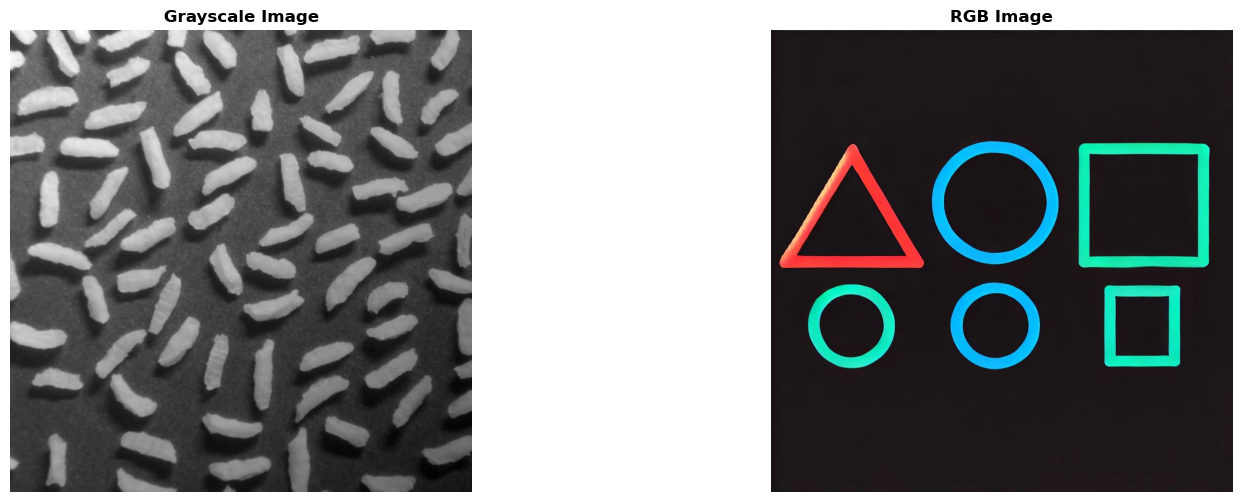

In [5]:
current_directory = os.getcwd()
gray_img_path = os.path.join(current_directory, "rice-shaded.tif")
colour_img_path = os.path.join(current_directory, "rgb01.jpg")
gray_img = cv2.imread(gray_img_path, cv2.IMREAD_GRAYSCALE) 
colour_img = cv2.imread(colour_img_path)
if colour_img is not None:
    colour_img = cv2.cvtColor(colour_img, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
if gray_img is not None:
    axes[0].imshow(gray_img, cmap='gray')
    axes[0].set_title(" Grayscale Image ", fontsize=12, fontweight='bold')
    axes[0].axis("off")
if colour_img is not None:
    axes[1].imshow(colour_img)
    axes[1].set_title("RGB Image", fontsize=12, fontweight='bold')
    axes[1].axis("off")
plt.show()


**Image Smoothing: The function will take as input an image and a value for sigma that will be used to smooth the image. I use the function fspecial to create the Gaussian filter and the function imfilter to perform correlation with it. Make sure that the width of your filter is at least two * sigma + 1, to fully capture the Gaussian. For example, if sigma is 2, you might use a filter that has a size of 5x5 (2*2+1). For sigma = 4, you might use a filter size of 9x9 (2*4+1).**

**Why Choose sigma = 2?**

Larger sigma values result in a stronger blur and smaller sigma values retain more details but might not smooth enough.But a value of 2 provides a balance between noise reduction and edge preservation.

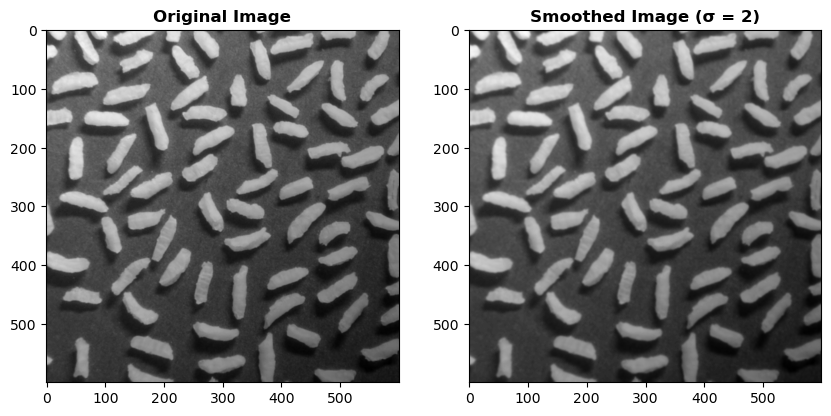

In [8]:
def fspecial(sigma):
    ksize = int((sigma * 2) + 1)
    if ksize % 2 == 0: 
        ksize += 1
    return ksize

def imfilter(img, ks):
    return cv2.GaussianBlur(img, (ks, ks), 0)

sigma = 2
ksize = fspecial(sigma)
smoothed_img = imfilter(gray_img, ksize)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(gray_img, cmap='gray')
plt.title('Original Image', fontsize=12, fontweight='bold')

plt.subplot(1, 2, 2)
plt.imshow(smoothed_img, cmap='gray')
plt.title(f'Smoothed Image (σ = {sigma})', fontsize=12, fontweight='bold')
plt.show()

Raw grayscale image are with noise and sharp edges. Smoothed image are processed using Gaussian smoothing (σ = 2, ksize = 5x5) to reduce noise while retaining object structures.

**Effects of Smoothing:**

Removes noise while keeping edges visible.

**My function will take an image as input and return two images. Each image will be the size of the original image. One will contain the x component of the image gradient for each pixel, the other will contain the y component of the gradient. Hint: Used padding to original image in order to keep the same size.** 

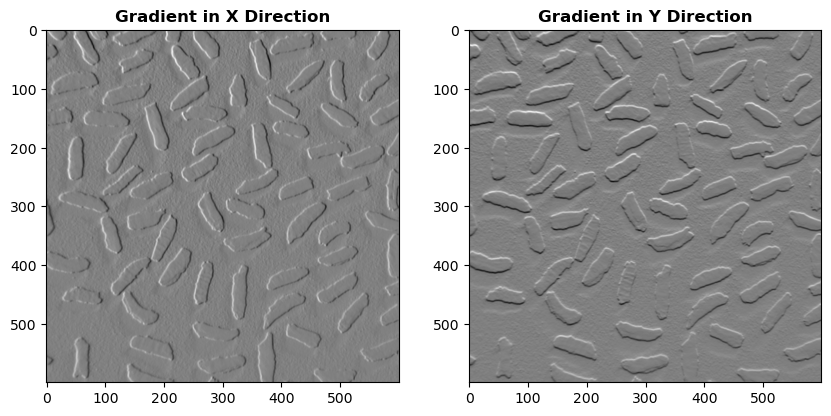

In [11]:
def compute_gradient(img):
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])  
    sobel_y = np.array([[-1, -2, -1],  [ 0,  0,  0], [ 1,  2,  1]])  

    grad_x = cv2.filter2D(img, ddepth=cv2.CV_32F, kernel=sobel_x, borderType=cv2.BORDER_REFLECT)
    grad_y = cv2.filter2D(img, ddepth=cv2.CV_32F, kernel=sobel_y, borderType=cv2.BORDER_REFLECT)
    return grad_x, grad_y

grad_x, grad_y = compute_gradient(gray_img)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(grad_x, cmap='gray')
plt.title('Gradient in X Direction', fontsize=12, fontweight='bold')

plt.subplot(1, 2, 2)
plt.imshow(grad_y, cmap='gray')
plt.title('Gradient in Y Direction', fontsize=12, fontweight='bold')
plt.show()

**Gradient in X Direction:**

Highlights edges in the horizontal direction. Detects changes along the left-right axis. Strong response at vertical edges of objects.

**Gradient in Y Direction:**

Highlights edges in the vertical direction. Detects changes along the top-bottom axis. Strong response at horizontal edges of objects.

**This function should take as input the two images produced by the previous function, which contain the x and y components of the gradient. It will return three images, which contain the magnitude of the gradient at each pixel, and the x and y components of the gradient direction.**

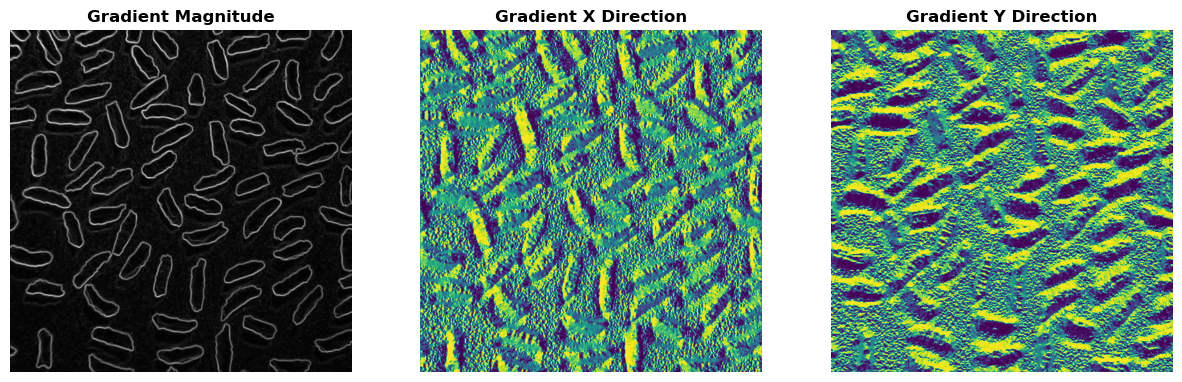

In [14]:
def compute_magnitude_direction(grad_x, grad_y):
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    direction_x = np.divide(grad_x, magnitude, out=np.zeros_like(grad_x), where=magnitude > 0)
    direction_y = np.divide(grad_y, magnitude, out=np.zeros_like(grad_y), where=magnitude > 0)
    return magnitude, direction_x, direction_y

magnitude, direction_x, direction_y = compute_magnitude_direction(grad_x, grad_y)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(magnitude, cmap='gray')
plt.title('Gradient Magnitude', fontsize=12, fontweight='bold')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(direction_x)
plt.title('Gradient X Direction', fontsize=12, fontweight='bold')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(direction_y)
plt.title('Gradient Y Direction', fontsize=12, fontweight='bold')
plt.axis('off')
plt.show()

**Gradient Magnitude:**

Shows the combined effect of X and Y gradients. Highlights object boundaries where intensity changes significantly.

**Gradient in X Direction:**

Detects horizontal edges (left-to-right transitions). High values indicate strong vertical structures.

**Gradient in Y Direction:**

Detects vertical edges (top-to-bottom transitions). High values highlight horizontal structures.

**Finally,combine these functions together to create a function that will find positions in the image in which the gradient is a local maxima, and “reasonably” large. This function will take three inputs: an image, sigma, and t.  We will only detect edges at pixels in which the magnitude of the gradient is greater than this threshold t. The output of this function will be a binary matrix. For every pixel, there will be a 1 if there is an edge at that pixel, and a zero if there is no edge.**

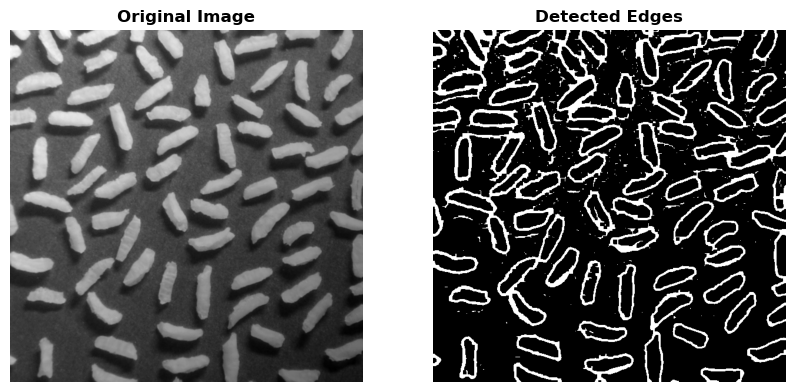

In [17]:
def detect_edges(image, sigma, t):
    size = fspecial(sigma)
    smoothed_img = imfilter(image, size)
    grad_x, grad_y = compute_gradient(image)
    magnitude, direction_x, direction_y = compute_magnitude_direction(grad_x, grad_y)
    kernel = np.ones((5, 5), np.uint8) 
    suppressed_magnitude = cv2.morphologyEx(magnitude, cv2.MORPH_CLOSE, np.ones((5, 5)))
    edge_map = np.zeros_like(suppressed_magnitude)
    edge_map[suppressed_magnitude > t] = 1
    return edge_map

edges = detect_edges(gray_img, 20, 45)   
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(gray_img, cmap='gray')
plt.title('Original Image', fontsize=12, fontweight='bold')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Detected Edges', fontsize=12, fontweight='bold')
plt.axis('off')
plt.show()

**Original Image:**

Displays the grayscale input image with rice-like objects. Contains smooth intensity transitions.

**Detected Edges:**

Shows binary edge detection output. Keeps strong edges (above a high threshold). Includes weak edges if connected to strong edges. Provides clear, continuous object boundaries.

**Show different results by varying the values of the parameters.**

sigma = 4

threshold = 125


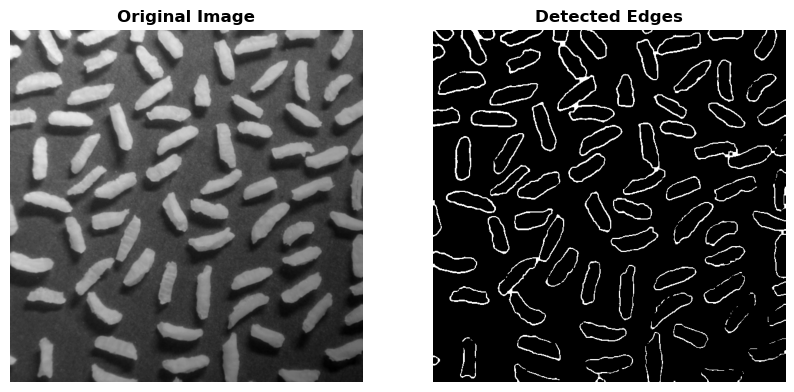

In [20]:
edges = detect_edges(gray_img, 4, 125)   
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(gray_img, cmap='gray')
plt.title('Original Image', fontsize=12, fontweight='bold')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Detected Edges', fontsize=12, fontweight='bold')
plt.axis('off')
plt.show()

**Add hysteresis to my edge detector. It should take two thresholds as input, along with the image and sigma. A pixel is an edge if the gradient magnitude is greater than the first threshold, but also if the gradient magnitude is bigger than the second threshold and it has a neighbor that is an edge (note that this is a recursive definition).**

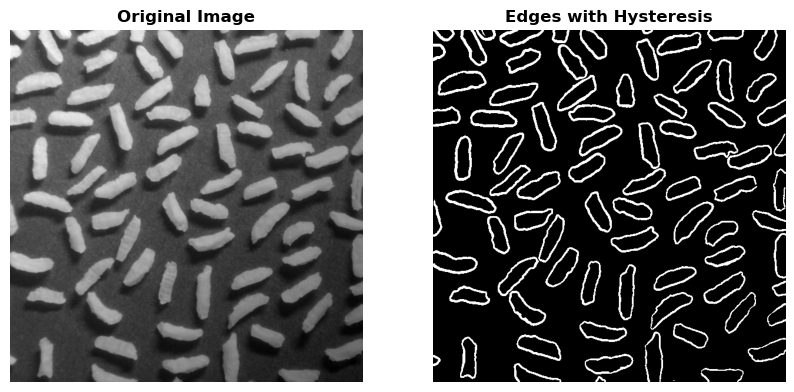

In [22]:
def hysteresis_threshold(image, sigma, t_low, t_high):
    size = fspecial(sigma)
    smoothed_img = imfilter(image, size)
    grad_x, grad_y = compute_gradient(smoothed_img)
    magnitude, _, _ = compute_magnitude_direction(grad_x, grad_y)
    M, N = magnitude.shape
    edge_map = np.zeros((M, N), dtype=np.uint8)
    strong_i, strong_j = np.where(magnitude >= t_high)
    weak_i, weak_j = np.where((magnitude >= t_low) & (magnitude < t_high))    
    edge_map[strong_i, strong_j] = 255  
    edge_map[weak_i, weak_j] = 75       

    def link_edges(i, j):
        
        if edge_map[i, j] == 75:
            edge_map[i, j] = 255
            for di in [-1, 0, 1]:
                for dj in [-1, 0, 1]:
                    if di == 0 and dj == 0:
                        continue
                    ni, nj = i + di, j + dj
                    if 0 <= ni < M and 0 <= nj < N:
                        link_edges(ni, nj)

    for i, j in zip(strong_i, strong_j):
        link_edges(i, j)
    edge_map[edge_map == 75] = 0
    return edge_map

edges_hysteresis = hysteresis_threshold(gray_img, 2, 17, 75)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(gray_img, cmap='gray')
plt.title('Original Image', fontsize=12, fontweight='bold')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(edges_hysteresis, cmap='gray')
plt.title('Edges with Hysteresis', fontsize=12, fontweight='bold')
plt.axis('off')
plt.show()

**Edges with Hysteresis:**

Shows a binary edge map obtained using hysteresis thresholding. Strong edges (high threshold) are preserved. Weak edges (low threshold) are kept only if connected to strong edges. Produces continuous and well-defined edges.

**Used a color image and don’t convert to grayscale.  Still need to ultimately output a binary image with edge locations marked. To answer this question, you will need to decide what a color edge is.  Do not need to find the “right” answer (there isn’t one). convert to any color space you like, but you must consider all channels. (E.g., conversing to HSV and only using V does not satisfy the requirements of this part of the assignment.)**

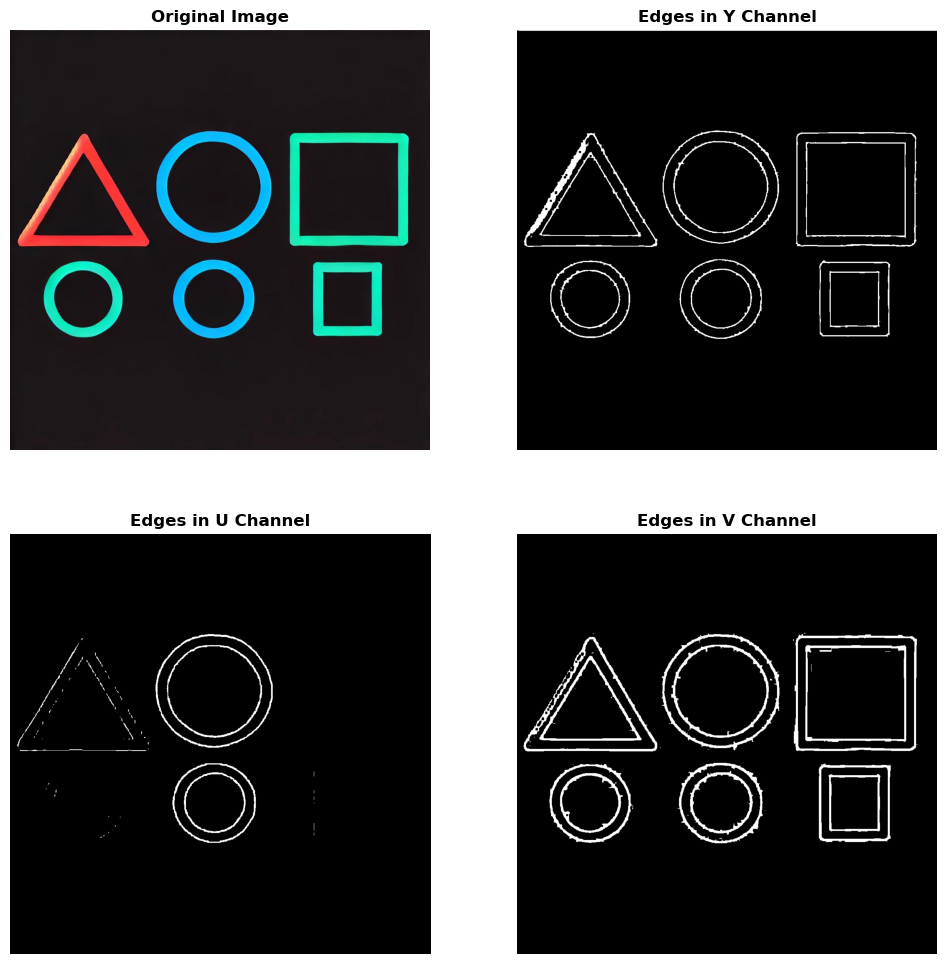

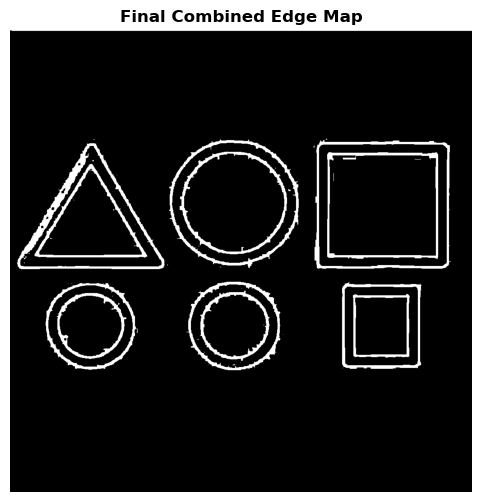

In [25]:
yuv_img = cv2.cvtColor(colour_img, cv2.COLOR_RGB2YUV)
y, u, v = cv2.split(yuv_img)
sigma = 2
threshold = 50
edges_y = detect_edges(y, sigma, threshold)
edges_u = detect_edges(u, sigma, threshold)
edges_v = detect_edges(v, sigma, threshold)

combined_edges = np.maximum(np.maximum(edges_y, edges_u), edges_v)
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes[0, 0].imshow(colour_img)
axes[0, 0].set_title("Original Image", fontsize=12, fontweight='bold')
axes[0, 0].axis("off")
axes[0, 1].imshow(edges_y, cmap='gray')
axes[0, 1].set_title("Edges in Y Channel", fontsize=12, fontweight='bold')
axes[0, 1].axis("off")
axes[1, 0].imshow(edges_u, cmap='gray')
axes[1, 0].set_title("Edges in U Channel", fontsize=12, fontweight='bold')
axes[1, 0].axis("off")
axes[1, 1].imshow(edges_v, cmap='gray')
axes[1, 1].set_title("Edges in V Channel", fontsize=12, fontweight='bold')
axes[1, 1].axis("off")
plt.show()
plt.figure(figsize=(6, 6))
plt.imshow(combined_edges, cmap='gray')
plt.title("Final Combined Edge Map", fontsize=12, fontweight='bold')
plt.axis("off")
plt.show()

**Perform edge detection at different scales using a Laplacian Pyramid implemented through differences of Gaussians at different scales.** 

In your results, explain how the Laplacian Pyramid was obtained (what scales did you consider for the Gaussians and why) and how did you perform the edge detection using the Laplacian pyramid.  Show how other values for the parameters would have changed the results.  Furthermore, compare your results with the results obtain for edge detection by just applying the Laplacian of Gaussian (LoG) transform.

**Some requirements:**

1.	You must implement a coarse-to-fine strategy.  That is, search for edges first at the coarsest resolution of your pyramid, and use those edges to refine your search for edges at finer resolutions.

2.	Keep in mind that Laplacian edge finding is based on zero crossings, so do not use any first order filters (e.g. Sobel) or edge finding strategies (e.g. Canny)

3.	You can use built in Laplacian edge finding functions but you must create and process the pyramid using your code

4.	Remember to compare the results of the pyramid analysis with an analysis of the image directly.  Again, for the latter result, you can use a built in function.  How are the edges different when you use the pyramid?


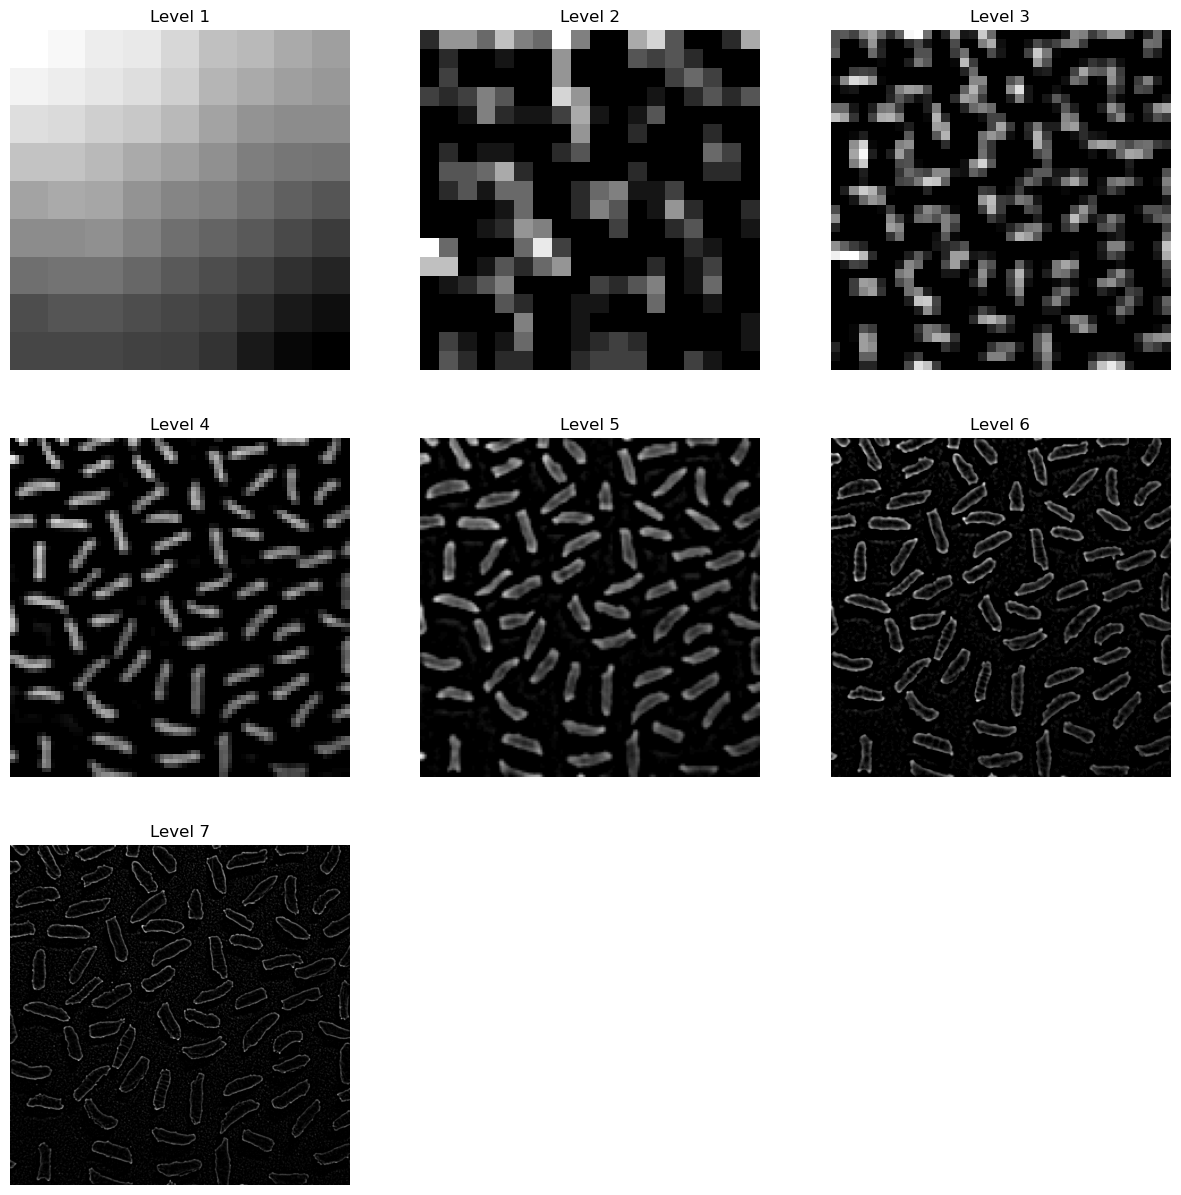

In [27]:
def lap_pyramid(img, n):
    gauss_pyr = [img]
    for i in range(1, n):
        blur = cv2.GaussianBlur(gauss_pyr[-1], (5, 5), sigmaX=2)
        downsample = cv2.resize(blur, (gauss_pyr[-1].shape[1] // 2, gauss_pyr[-1].shape[0] // 2))
        gauss_pyr.append(downsample)

    lap_pyr = []
    for i in range(7 - 1):
        upsampled = cv2.resize(gauss_pyr[i + 1], (gauss_pyr[i].shape[1], gauss_pyr[i].shape[0]))
        laplacian = cv2.subtract(gauss_pyr[i], upsampled)
        lap_pyr.append(laplacian)
    lap_pyr.append(gauss_pyr[-1])
    return lap_pyr

laplacian_pyr= lap_pyramid(gray_img, 7)
laplacian_pyr.reverse()

grid_rows, grid_cols = 3, 3

fig, axs = plt.subplots(grid_rows, grid_cols, figsize=(15, 15))

for i, img in enumerate(laplacian_pyr[:7]):
    row, col = divmod(i, grid_cols)  
    axs[row, col].imshow(img, cmap='gray')
    axs[row, col].set_title(f"Level {i+1}")
    axs[row, col].axis('off')
for i in range(7, grid_rows * grid_cols):
    row, col = divmod(i, grid_cols)
    axs[row, col].axis('off')

plt.show()

**Conclusion**

The Laplacian Pyramid was obtained by progressively downsampling an image with Gaussian blurring and then computing the difference between adjacent levels. Edge detection was performed at multiple scales using the Laplacian Pyramid, capturing different levels of edge details. The LoG method detects edges at a single scale, making it less flexible compared to the multi-scale Laplacian Pyramid. Adjusting parameters such as the number of levels, blur sigma, and kernel size significantly affects the results.


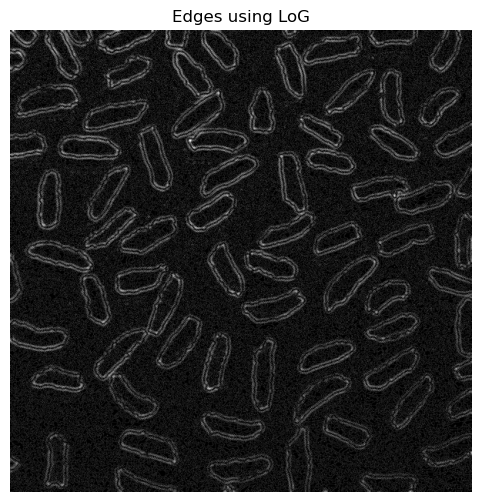

In [29]:
log_filtered = cv2.GaussianBlur(gray_img, (5, 5), sigmaX=2)
log_edges = cv2.Laplacian(log_filtered, cv2.CV_64F)
dist = cv2.convertScaleAbs(log_edges)  
plt.figure(figsize=(6, 6))
plt.imshow(dist, cmap='gray')
plt.title("Edges using LoG")
plt.axis('off')
plt.show()

**Conclusion**

LoG edge detection is a single-scale method, meaning it applies Gaussian smoothing before detecting edges at a fixed resolution. Laplacian Pyramid edge detection is a multi-scale method, which progressively detects edges at different levels of detail, making it more powerful for hierarchical edge refinement.

**Effect of Parameter Changes**

1. Increasing or Decreasing the Number of Levels Leads to more downsampling. The coarsest level becomes highly blurred. Finer levels have more refined edge details. Fewer levels retains more details at each level. The difference between adjacent levels is smaller.

2. Changing the Gaussian Blur Sigma produces stronger smoothing. Removes more noise but can also blur important edge details. Lower sigmaX retains more sharp details and can lead to more noise being captured in the Laplacian Pyramid.